In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [3]:
shapes = cv.imread("images/contourss.png")
shapes.shape

(1080, 1920, 3)

In [4]:
print("Total no of pixels = {}".format(1080*1920*3))

Total no of pixels = 6220800


(-0.5, 1919.5, 1079.5, -0.5)

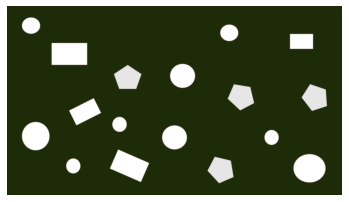

In [5]:
plt.imshow(shapes)
plt.axis("off")

(-0.5, 1919.5, 1079.5, -0.5)

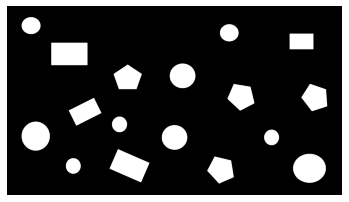

In [6]:
gray_shapes = cv.cvtColor(shapes, cv.COLOR_BGR2GRAY)
_, thresh1 = cv.threshold(gray_shapes, 50, 255, cv.THRESH_BINARY)

plt.imshow(thresh1, cmap="Greys_r")
plt.axis("off")

(-0.5, 1919.5, 1079.5, -0.5)

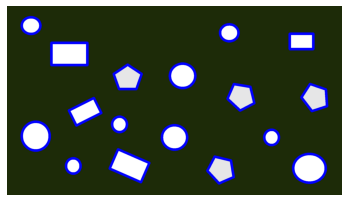

In [7]:
contours, hierarchy = cv.findContours(thresh1, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
img_with_contours = cv.drawContours(shapes, contours, -1,(0,0,255),13)

# -1 - indicates all contour indexes
# 3 - thickness of contour line

plt.imshow(img_with_contours)
plt.axis("off")

In [8]:
# filter internal contours, get information about children

filtered_contours = []
has_a_child = []

for contour, h in zip(contours, hierarchy[0]):
    if h[3] == -1:
        filtered_contours.append(contour)
    if h[2] != -1:
        has_a_child.append(1)
    else:
        has_a_child.append(0)
        
print(has_a_child)    


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [9]:
# Get all useful information from contours
features_list = []

for contour, childs in zip(filtered_contours, has_a_child):
    moments = cv.moments(contour)  # Central moments from OpenCV: eg, area, centroid
    hu_moments = cv.HuMoments(moments)  # Hu moments competed from Central Moments: 7 features
    
    contour_area = cv.contourArea(contour)
    arc_length = cv.arcLength(contour, True)
    if arc_length > 0:
        features = {x: hu[0] for x, hu in enumerate(hu_moments)}
        features['circularity'] = (4*3.14*contour_area)/arc_length**2
        features['has_child'] = childs
        features_list.append(features)
        

In [10]:
# Save data as pd.DataFrame
import pandas as pd

pd.options.display.float_format = "{:,.2f}".format
df = pd.DataFrame(features_list)
df


,0,1,2,3,4,5,6,circularity,has_child
0,0.16,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.90,0
1,0.16,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.77,0
2,0.16,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.89,0
3,0.19,0.01,0.00,0.00,-0.00,-0.00,-0.00,0.64,0
4,0.16,0.00,0.00,0.00,-0.00,-0.00,0.00,0.90,0
5,0.16,0.00,0.00,0.00,-0.00,-0.00,0.00,0.90,0
6,0.16,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.90,0
7,0.16,0.00,0.00,0.00,-0.00,-0.00,0.00,0.89,0
8,0.19,0.01,0.00,0.00,-0.00,-0.00,0.00,0.63,0
9,0.16,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.77,0


In [11]:
# Cluster with KMeans

from sklearn.cluster import KMeans
import numpy as np

from sklearn import preprocessing

In [12]:
# Normalize the fratures: Scale to 0-1
x = df.values  # returns a numpy array
normalizer = preprocessing.Normalizer()
x_scaled = normalizer.fit_transform(x)
df = pd.DataFrame(x_scaled)

# Cluster the transformed dataset
kmeans = KMeans(n_clusters=6, random_state=0).fit(df)
print(kmeans.labels_)


[0 2 0 3 0 0 0 0 5 2 2 2 0 1 4 0 0]


In [13]:
# Matplotlib Colors
colors = [(255,0,0), (255,255,0), (255,0,255), (0,255,0), (0,255,255), (0,0,255)]
for contour, label in zip(filtered_contours, kmeans.labels_):
    classified = cv.drawContours(shapes, [contour], 0, colors[label], 13)
    
print(df)

      0    1    2    3     4     5     6    7    8
0  0.17 0.00 0.00 0.00 -0.00 -0.00 -0.00 0.98 0.00
1  0.21 0.00 0.00 0.00 -0.00 -0.00 -0.00 0.98 0.00
2  0.18 0.00 0.00 0.00 -0.00 -0.00 -0.00 0.98 0.00
3  0.28 0.01 0.00 0.00 -0.00 -0.00 -0.00 0.96 0.00
4  0.17 0.00 0.00 0.00 -0.00 -0.00  0.00 0.98 0.00
5  0.17 0.00 0.00 0.00 -0.00 -0.00  0.00 0.98 0.00
6  0.17 0.00 0.00 0.00 -0.00 -0.00 -0.00 0.98 0.00
7  0.18 0.00 0.00 0.00 -0.00 -0.00  0.00 0.98 0.00
8  0.29 0.01 0.00 0.00 -0.00 -0.00  0.00 0.96 0.00
9  0.21 0.00 0.00 0.00 -0.00 -0.00 -0.00 0.98 0.00
10 0.21 0.00 0.00 0.00  0.00  0.00 -0.00 0.98 0.00
11 0.21 0.00 0.00 0.00 -0.00 -0.00  0.00 0.98 0.00
12 0.17 0.00 0.00 0.00  0.00  0.00  0.00 0.98 0.00
13 0.24 0.01 0.00 0.00  0.00  0.00 -0.00 0.97 0.00
14 0.23 0.01 0.00 0.00  0.00 -0.00  0.00 0.97 0.00
15 0.18 0.00 0.00 0.00 -0.00 -0.00 -0.00 0.98 0.00
16 0.18 0.00 0.00 0.00  0.00  0.00  0.00 0.98 0.00


(-0.5, 1919.5, 1079.5, -0.5)

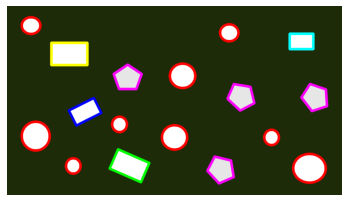

In [14]:
plt.imshow(classified)
plt.axis("off")